In [ ]:
%cd /content/

/content


In [ ]:
!mkdir video_classification
%cd video_classification

mkdir: cannot create directory ‘video_classification’: File exists
/content/video_classification


In [ ]:
%%capture
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official
!pip install remotezip
!pip install tf-models-official
!pip install -q mediapy


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import os

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

import mediapy as media


In [ ]:
#@title

def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]


def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [ ]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [ ]:
FILES_PER_CLASS = 100

In [ ]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [ ]:
classes

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BlowDryHair',
 'BlowingCandles',
 'BodyWeightSquats',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BreastStroke',
 'BrushingTeeth',
 'CleanAndJerk',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'CuttingInKitchen',
 'Diving',
 'Drumming',
 'Fencing',
 'FieldHockeyPenalty',
 'FloorGymnastics',
 'FrisbeeCatch',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HandstandWalking',
 'HeadMassage',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Knitting',
 'LongJump',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'MoppingFloor',
 'Nunchucks',
 'ParallelBars',
 'PizzaTossing',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'Play

In [ ]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

In [ ]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [ ]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [ ]:
files_subset = select_subset_of_classes(files_for_class, classes_1, FILES_PER_CLASS)
list(files_subset.keys())

['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [ ]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [ ]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [ ]:
 URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir,
                                       classes_1=classes_1)

train :


100%|██████████| 750/750 [08:14<00:00,  1.52it/s]


val :


100%|██████████| 250/250 [02:45<00:00,  1.51it/s]


test :


100%|██████████| 250/250 [02:35<00:00,  1.61it/s]


In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 1250


In [ ]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                          output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

In [ ]:
for frames, labels in train_ds.take(NUM_CLASSES):
  print(labels)

tf.Tensor([17  8  4 16 11  6  4  8], shape=(8,), dtype=int16)
tf.Tensor([ 9 18 10 15 10 22 11 24], shape=(8,), dtype=int16)
tf.Tensor([22 11 14  2 22 18  7 19], shape=(8,), dtype=int16)
tf.Tensor([21  8 20  2 19 22  2  1], shape=(8,), dtype=int16)
tf.Tensor([17  4 18 15  7 17 11 14], shape=(8,), dtype=int16)
tf.Tensor([ 3 23 12  3 22  8 11 17], shape=(8,), dtype=int16)
tf.Tensor([ 4  9 21 23  0 21 14 19], shape=(8,), dtype=int16)
tf.Tensor([ 4  7 13 21  4  7  4  5], shape=(8,), dtype=int16)
tf.Tensor([10 20  4  8  5 24 14 19], shape=(8,), dtype=int16)
tf.Tensor([ 0 18  0 12  0 11  8 16], shape=(8,), dtype=int16)
tf.Tensor([ 7 23  5 12  4 24 18 22], shape=(8,), dtype=int16)
tf.Tensor([ 6 12 11  0 13  6  3 10], shape=(8,), dtype=int16)
tf.Tensor([ 7 14  1 10 17 19 17 11], shape=(8,), dtype=int16)
tf.Tensor([17  3 10 11 20  5 19 16], shape=(8,), dtype=int16)
tf.Tensor([ 3 24 19 10  0 19  3  2], shape=(8,), dtype=int16)
tf.Tensor([23 11 14  3  1 15 23  5], shape=(8,), dtype=int16)
tf.Tenso

In [ ]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)



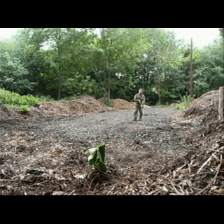
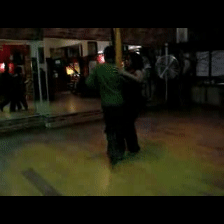
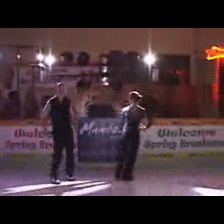
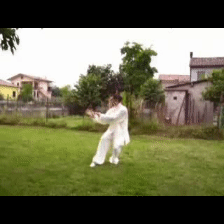
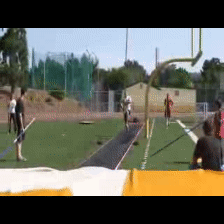
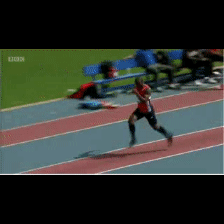
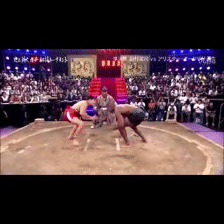
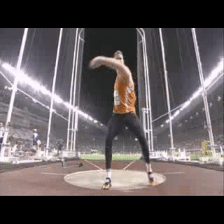

In [ ]:
videos, labels = next(iter(train_ds))
media.show_videos(videos.numpy(), codec='gif', fps=8)

In [ ]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
batch_size, num_frames, resolution, backbone, NUM_CLASSES

(8,
 8,
 224,
 25)

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, NUM_CLASSES)

In [ ]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [ ]:
num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
train_ds, test_ds

(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
94/94 [==============================] - 215s 2s/step - loss: 1.3161 - accuracy: 0.6987 - val_loss: 0.4179 - val_accuracy: 0.8960
Epoch 2/2
94/94 [==============================] - 112s 1s/step - loss: 0.1970 - accuracy: 0.9480 - val_loss: 0.2050 - val_accuracy: 0.9520


In [ ]:
model.save('saved_model/my_model')

In [ ]:
import shutil

# Specify the folder path to be downloaded
folder_path = '/vide_classification/saved_model/my_model'  # Replace with the actual path to your folder

# Create a zip file of the folder
shutil.make_archive('/video_classification/my_model', 'zip', folder_path)


'/video_classification/my_model.zip'

In [ ]:
# Download the zip file
from google.colab import files

files.download('/video_classification/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip /video_classification/my_model.zip -d video_classification/my_model

Archive:  /video_classification/my_model.zip
warning [/video_classification/my_model.zip]:  zipfile is empty


In [ ]:
model = tf.keras.models.load_model('/content/video_classification/saved_model/my_model')

# Check its architecture
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet_1 (Movinet)         ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])
  plt.savefig("loss.png")
  plt.show()

plot_history(results)

In [ ]:
model.evaluate(test_ds, return_dict=True)

32/32 [==============================] - 40s 997ms/step - loss: 0.1782 - accuracy: 0.0440


{'loss': 0.17822042107582092, 'accuracy': 0.04399999976158142}

Confusion matrix

In [ ]:
def get_actual_predicted_labels(model,dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
actual, predicted = get_actual_predicted_labels(model,test_ds)

32/32 [==============================] - 43s 963ms/step


In [ ]:
labels = classes_1

In [ ]:
print(actual, tf.cast(predicted, tf.int16),labels, len(labels),sep = '\n')

tf.Tensor(
[ 8  8  8  8  8  8  8  8  8  8 14 14 14 14 14 14 14 14 14 14 18 18 18 18
 18 18 18 18 18 18 13 13 13 13 13 13 13 13 13 13 11 11 11 11 11 11 11 11
 11 11 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4  4  5  5
  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7 15 15 15 15 15 15
 15 15 15 15  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3
 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 17 17 17 17
 17 17 17 17 17 17 24 24 24 24 24 24 24 24 24 24  6  6  6  6  6  6  6  6
  6  6 20 20 20 20 20 20 20 20 20 20 23 23 23 23 23 23 23 23 23 23 19 19
 19 19 19 19 19 19 19 19  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2
  2  2  2  2  9  9  9  9  9  9  9  9  9  9 12 12 12 12 12 12 12 12 12 12
 16 16 16 16 16 16 16 16 16 16], shape=(250,), dtype=int16)
tf.Tensor(
[ 8  8  8  8  8  8  8  8  8 23 14 14 14 14 14 14 14 14 14 14 18 18 18 18
 18 18 18 18 18 18 13 13 13 13 14 13 13 13 14 13 11 11 11 11 11 23 11 11
 11 11 10 10 10 10 10 10 13 10 10 10  4  4

In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns
import pandas as pd
con_mat = tf.math.confusion_matrix(labels=actual, predictions=predicted).numpy()
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat,
                     index = labels,
                     columns = labels)

figure = plt.figure(figsize=(9, 9))
sns.heatmap(con_mat_df, annot=True, fmt='g')
# sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion_martix_test.png',bbox_inches = 'tight')
plt.show()

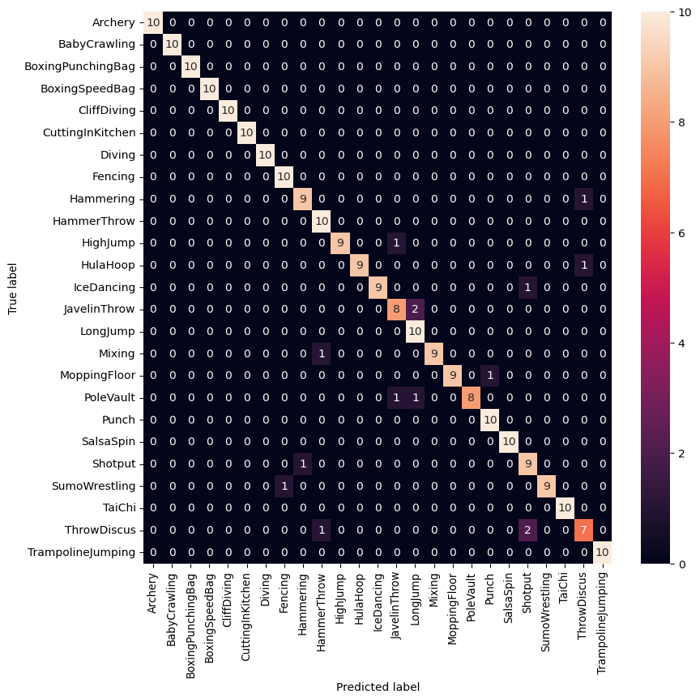

In [ ]:
from PIL import Image
import IPython.display as display

# Open the image
image_path = '/content/video_classification/Confusion_martix_test.png'  # Replace with the actual path to your image
image = Image.open(image_path)

# Define the desired output size
output_size = (700, 700)  # Replace with your desired size

# Resize the image
image_resized = image.resize(output_size)

# Display the resized image
display.display(image_resized)


In [ ]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

In [ ]:
import numpy as np

classes_one_hot = classes_1

# Create a list of unique classes
unique_classes = np.unique(classes_one_hot)

# Create one-hot encoded labels
labels = []
for c in classes_1:
    label = np.asarray([1 if c == cls else 0 for cls in unique_classes])
    labels.append(label)

labels_1 = np.asarray(labels)

# print(labels_1)

In [ ]:
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k(probs, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

In [ ]:
!mkdir sample_gifs

In [ ]:
import os
import random
from moviepy.editor import VideoFileClip

# Specify the directory path
directory = '/content/video_classification/UCF101_subset/test'
save_dir = '/content/video_classification/sample_gifs'

# Get a list of subdirectories within the main directory
subdirectories = [subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]


for i in range(5):
    subdir = random.choice(subdirectories)
    # Iterate over each subdirectory
    # for subdir in subdirectories:
    subdir_path = os.path.join(directory, subdir)
    # Get a list of files within the subdirectory with the .avi extension
    files = [file for file in os.listdir(subdir_path) if file.endswith('.avi')]

    # Randomly select a file from the files list
    random_file = random.choice(files)

    # Print the selected file
    print("Random .avi file from", subdir, ":", random_file)
    input = directory+'/'+subdir+'/'+random_file
    clip = VideoFileClip(input)
    output = save_dir+'/'+random_file.split('.')[0]+'.gif'
    print(output)
    clip.write_gif(output)


Random .avi file from BoxingPunchingBag : v_BoxingPunchingBag_g19_c04.avi
/content/video_classification/sample_gifs/v_BoxingPunchingBag_g19_c04.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_BoxingPunchingBag_g19_c04.gif with imageio.


Random .avi file from Diving : v_Diving_g08_c04.avi
/content/video_classification/sample_gifs/v_Diving_g08_c04.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_Diving_g08_c04.gif with imageio.


t:  77%|███████▋  | 112/146 [00:00<00:00, 1115.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/video_classification/UCF101_subset/test/Diving/v_Diving_g08_c04.avi, 230400 bytes wanted but 0 bytes read,at frame 145/146, at time 4.84/4.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Random .avi file from BoxingSpeedBag : v_BoxingSpeedBag_g02_c01.avi
/content/video_classification/sample_gifs/v_BoxingSpeedBag_g02_c01.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_BoxingSpeedBag_g02_c01.gif with imageio.


Random .avi file from TaiChi : v_TaiChi_g25_c01.avi
/content/video_classification/sample_gifs/v_TaiChi_g25_c01.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_TaiChi_g25_c01.gif with imageio.


Random .avi file from BoxingPunchingBag : v_BoxingPunchingBag_g19_c04.avi
/content/video_classification/sample_gifs/v_BoxingPunchingBag_g19_c04.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_BoxingPunchingBag_g19_c04.gif with imageio.


In [ ]:
save_dir = '/content/video_classification/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(244, 244))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)

1/1 [==============================] - 16s 16s/step
TaiChi 0.943629
Archery 0.048581127
HulaHoop 0.0042229756
Shotput 0.001335138
HammerThrow 0.0012666958


1/1 [==============================] - 15s 15s/step
Diving 0.9852681
Hammering 0.0030979472
PoleVault 0.0027687023
CliffDiving 0.00231408
ThrowDiscus 0.0015181266


1/1 [==============================] - 11s 11s/step
BoxingPunchingBag 0.9077302
BoxingSpeedBag 0.024371305
TrampolineJumping 0.016882403
Punch 0.011840213
SalsaSpin 0.0110306945


1/1 [==============================] - 10s 10s/step
BoxingSpeedBag 0.96612173
HammerThrow 0.016443737
BoxingPunchingBag 0.009780452
Mixing 0.004280845
Punch 0.00077294966


In [ ]:
save_dir = '/content/video_classification/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(244, 244))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)

1/1 [==============================] - 0s 409ms/step
TaiChi 0.943629
Archery 0.048581127
HulaHoop 0.0042229756
Shotput 0.001335138
HammerThrow 0.0012666958


1/1 [==============================] - 0s 333ms/step
Diving 0.9852681
Hammering 0.0030979472
PoleVault 0.0027687023
CliffDiving 0.00231408
ThrowDiscus 0.0015181266


1/1 [==============================] - 0s 256ms/step
BoxingPunchingBag 0.9077302
BoxingSpeedBag 0.024371305
TrampolineJumping 0.016882403
Punch 0.011840213
SalsaSpin 0.0110306945


1/1 [==============================] - 0s 362ms/step
BoxingSpeedBag 0.96612173
HammerThrow 0.016443737
BoxingPunchingBag 0.009780452
Mixing 0.004280845
Punch 0.00077294966
